<h1><center>Sentiment Analysis of 10K Documents 🏦 </center></h1>sec_fillings_df.date.dt.year

# Table of Contents

* [Introduction](#Intro)
* [Libraries](#Lib)
* [Web Scrapping 10-K fillings](#data)

# Introduction <a class="anchor" id="Intro"></a>
The last few decades the amount of data released by companies in their annual reports has increased in volume. Till a couple of years back to analyze this data was getting ardious and soon information extraction techiniques were used to leverage the numerical data in these documents.
The textual data , however was not being leveraged enough and was only analyzed manually by financial analysts.Due to the growing volume of this textual data the effort needed to manually analyse this was proving to be inefficient.It was also believed that it did not help in futher evaluating and estimating the company's performance any better.

This belief changed after the futher research in this domain and one such white paper called 'Lazy prices' proved that analyzing the text in the 10-K fillings of companies revealed future earnings patterns of the companies , if not having an immediate effect in the stock Market.

This project will use the latest advancements in NLP and deeplearning to recognize these patterns from the companies 10-K fillings from the last decade.

# Libraries 📚 <a class="anchor" id="Lib"></a>

In [540]:
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm

from ratelimit import limits, sleep_and_retry

import Edgar_scrapper

import re
import spacy
import numpy as np

In [2]:
from nltk.tokenize import word_tokenize,sent_tokenize

In [3]:
import time
import unicodedata

In [4]:
import sys

In [20]:
import nltk

In [5]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.chunk.util import tree2conlltags, conlltags2tree
from nltk.corpus import conll2000

In [6]:
import contractions

In [35]:
#!pip install gensim

In [203]:
#Import Dictionary
from gensim import corpora

In [490]:
from collections import defaultdict
import itertools

In [567]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer

In [638]:
import seaborn as sns

In [1246]:
#!python3 -m spacy download en_core_web_md

     |████████████████████████████████| 47.1 MB 43.7 MB/s eta 0:00:01     |█████████████████████▉          | 32.1 MB 43.7 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [3]:
#nlp = spacy.load('en_core_web_md')
#from spacy import en_core_web_md
nlp = spacy.load('/Users/vaishali/opt/anaconda3/envs/Capstone3/lib/python3.8/site-packages/en_core_web_md/en_core_web_md-3.0.0')

In [193]:
pd.set_option('display.max_colwidth',200)

## Scrapping data from goverment Edgar fillings website 💻 <a class="anchor" id="data"></a>

In [3]:
edgar_access = Edgar_scrapper.EdgarAccess()

In [4]:
def get_fillings(fillings_ticker,fillings_cik, doc_type, start=0, count=60):
    fillings_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK={}\
            &type={}&start={}&count={}&owner=exclude&output=atom'.format(fillings_cik, doc_type, start, count)
    fillings_html = edgar_access.get(fillings_url)
    fillings_soup = BeautifulSoup(fillings_html, features="html.parser")

    fillings_list = [
        (fillings_ticker,
         fillings_cik,
         link.find('filing-date').getText(),
         link.find('filing-href').getText())
         #link.find('filing-type').getText())
        for link in fillings_soup.find_all('entry')]

    return fillings_list

In [5]:
ticker_ciks = pd.read_csv('tickers.csv')

In [6]:
sample_ticker = pd.DataFrame(data={'ticker' : ['AMC'],'cik':[1411579]})

In [7]:
sec_fillings_df = pd.DataFrame(columns=['ticker','cik','date','annual_report_url','filling_text'])

In [8]:
for ticker, cik in sample_ticker.values:
    temp = pd.DataFrame(data = get_fillings(ticker,cik, '10-K'),columns=['ticker','cik','date','annual_report_url'])
    sec_fillings_df = sec_fillings_df.append(temp,ignore_index = True)

del(temp)

In [9]:
sec_fillings_df.annual_report_url = sec_fillings_df.annual_report_url.\
                                    replace('-index.htm', '.txt',regex=True)\
                                    .replace('.txtl', '.txt',regex=True) 

In [10]:
sec_fillings_df

,ticker,cik,date,annual_report_url,filling_text
0,AMC,1411579,2021-03-12,https://www.sec.gov/Archives/edgar/data/1411579/000141157921000006/0001411579-21-000006.txt,NaN
1,AMC,1411579,2020-02-28,https://www.sec.gov/Archives/edgar/data/1411579/000141157920000027/0001411579-20-000027.txt,NaN
2,AMC,1411579,2019-03-01,https://www.sec.gov/Archives/edgar/data/1411579/000141157919000013/0001411579-19-000013.txt,NaN
3,AMC,1411579,2018-03-01,https://www.sec.gov/Archives/edgar/data/1411579/000141157918000014/0001411579-18-000014.txt,NaN
4,AMC,1411579,2017-03-10,https://www.sec.gov/Archives/edgar/data/1411579/000141157917000021/0001411579-17-000021.txt,NaN
5,AMC,1411579,2016-03-08,https://www.sec.gov/Archives/edgar/data/1411579/000104746916010880/0001047469-16-010880.txt,NaN
6,AMC,1411579,2015-03-10,https://www.sec.gov/Archives/edgar/data/1411579/000104746915001918/0001047469-15-001918.txt,NaN
7,AMC,1411579,2014-03-04,https://www.sec.gov/Archives/edgar/data/1411579/000104746914001769/0001047469-14-001769.txt,NaN


## Downloading Individual fillings documents.

In [12]:
for index,row in tqdm(sec_fillings_df.iterrows(),desc='Downloading Fillings', \
                      unit='filling',total=len(sec_fillings_df)):
    filing_href = row['annual_report_url'] 
    report_txt= edgar_access.get(filing_href)
    #time.sleep(60)
    report_soup = BeautifulSoup(report_txt, "html")
    avalibility_10k = False
    for document in report_soup.find_all('document'): 
        if(re.match(r'\s+10-K',document.find('type').prettify().splitlines()[1])):
            sec_fillings_df.iloc[index]['filling_text'] = document
            avalibility_10k = True
            break
    if not avalibility_10k:
        print("Documents not available right now")
        print(report_soup.prettify())
        break

In [13]:
#sec_fillings_df.to_feather("../data/interim/sec_fillings_df.feather")

## Normalize corpus

### Replace Special characters

In [13]:
def extract_text(document):
    document = document.getText().splitlines()
    document = [line for line in document if re.match(r'\w+',line)]
    #document = [p_tag.getText() for p_tag in document.find_all(['p','font']) if re.match(r'\w+',p_tag.getText())]
    document = [line.replace(u'\xa0', u' ') for line in document]
    document = [line.replace(u'\u200b', u'') for line in document]
    document = [line.replace(u':', u' ') for line in document]
    document = [line.replace(r'[^(A-Za-z)|(0-9) ]+', '') for line in document]
    document = '\n'.join(document)
    document = document.lower()
    return document

In [15]:
#sec_fillings_df['filling_text_cleaned'] = [extract_text(document) for document in sec_fillings_df['filling_text']]

In [819]:
#sample_10k = extract_text(sec_fillings_df.iloc[0]['filling_text'])

In [820]:
#sample_10k = sample_10k.lower()

In [881]:
#sample_sent = sent_tokenize(sample_10k)[10:200]

In [882]:
#sample_sent_word = [word_tokenize(line) for line in sample_sent]

In [14]:
def repl(m):
    #sent = ' '.join([chars for chars in m.groups() if not chars==''])
    sent = ' '.join(m.groups())
    return sent

### Remove accented text

In [15]:
def remove_special_chars(document):
    document = unicodedata.normalize('NFKD', document).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return document

In [16]:
def seperate_num_strings(document):
    for i,line in enumerate(document):
        for j,word in enumerate(line):
            word = re.sub(r'([a-z]+)([0-9]+)',repl,word).strip()
            word = re.sub(r'([0-9]+)([a-z]+)',repl,word).strip()
            #line[j] = re.sub(' +', ' ',line[j])
            #line[j] = re.sub('\. +','.',line[j])
            #line[j] = re.sub('- +','-',line[j])
            #line[j] = re.sub(' +-','-',line[j])
            #line[j] = re.sub(' +%','%',line[j])
            #line[j] = re.sub('\$ +','$',line[j])
            line[j] = word
        document[i] = line
    return document

In [1182]:
#seperate_num_strings(sample_sent_word)

In [1186]:
line = 'we     had      $ 7.  777 % million covid -19 432babali345'

In [1189]:
line = re.sub(r'([a-z]+)([0-9]+)',repl,line)

In [1190]:
re.sub(r'([0-9]+)([a-z]+)',repl,line)

'we     had      $ 7.  777 % million covid -19 432 babali 345'

In [1097]:
re.sub('(\.|$) +',lambda x: ''.join(x.groups()),line)

'we     had      $ 7.777 % milliom'

In [986]:
re.match(r'([0-9]*)([a-z]*)([0-9]*)|([a-z\-][0-9]+)','covid-19')

<re.Match object; span=(0, 5), match='covid'>

### Tokenize

In [17]:
def tokenize(document):
    document_senttokenized = sent_tokenize(document)
    document_wordtokenized = [word_tokenize(line) for line in document_senttokenized]
    return document_wordtokenized

In [22]:
#sample_10k_tokenized = tokenize(sample_10k)

### Stemming

In [21]:
stemmer = nltk.porter.PorterStemmer()

In [22]:
def nltk_stemmer(document):
    stemmer = nltk.porter.PorterStemmer()
    document = [[stemmer.stem(word) for word in line] for line in document]   
    return document

In [25]:
#sample_10k_stemmed = nltk_stemmer(sample_10k_tokenized)

### Lemmatization

In [23]:
def nltk_lemmatizer(document):
    lemmatizer = WordNetLemmatizer()
    document = [[lemmatizer.lemmatize(word) for word in line] for line in document]
    return document

In [24]:
#sample_10k_lemmatized = nltk_lemmatizer(sample_10k_stemmed)

### Remove Stopwords

In [25]:
stop_words = set(stopwords.words('english')) 

In [26]:
def remove_stopwords(document):
    document = [[word for word in line if not word in stop_words] for line in document]
    return document

In [32]:
#sample_10k_nostopwords = remove_stopwords(sample_10k_lemmatized)

### Get size of double list

In [27]:
def get_size_double_list(double_list):
    size = 0
    for line in double_list:
        for word in line:
            size+= sys.getsizeof(word)
    return size/(1024**2)

In [35]:
#print("total size of {} is {}Mb".format("sample_10k_stemmed",get_size_double_list(sample_10k_stemmed)))

#print("total size of {} is {}Mb".format("sample_10k_word_tokenized",get_size_double_list(sample_10k_tokenized)))

#print("total size of {} is {}Mb".format("sample_10k_lemmatized",get_size_double_list(sample_10k_lemmatized)))

#print("total size of {} is {}Mb".format("sample_10k_lemmatized",get_size_double_list(sample_10k_nostopwords)))

### Contractions

In [28]:
def replace_contractions(document):
    document = [contractions.fix(line) for line in document]
    return document

### Removing more special characters

In [29]:
#sample_10k_nocontractions = remove_contractions(sample_10k_nostopwords)

In [913]:
def remove_specific_chars(document):
    char_list = ['.',',','$','(',')','%','#','&',"'","'s",'*','+','/','.','``']
    document = [[word for word in line if not word in char_list] for line in document]
    return document

In [956]:
def remove_numbers(document):
    document = [[word for word in line if not re.match('^[\,\.\/\d-]+$',word)] for line in document]
    return document

In [30]:
def normalize_document(document,lemmatize = False, stemming = False, rm_contractions = False ,rm_stopwords = False):
    
    document = extract_text(document)
    document = remove_special_chars(document)
    document = tokenize(document)
    
    document = seperate_num_strings(document)
    
    
    if lemmatize:
        document = nltk_lemmatizer(document)
    elif stemming:
        document = nltk_stemmer(document)
    if rm_stopwords:
        document = remove_stopwords(document)
    
    document = [' '.join(line) for line in document]
    
    if rm_contractions:
        document = replace_contractions(document)
    
    document = '\n'.join(document)
    
    return document
    

In [1193]:
sec_fillings_df['normalized_filling'] = ""

In [1194]:
for index,row in tqdm(sec_fillings_df.iterrows(),desc='normalizing Fillings', \
                      unit='filling',total=len(sec_fillings_df)):
    document = row.filling_text
    #print(type(normalize_document(document)))
    sec_fillings_df.at[index,'normalized_filling'] = normalize_document(document)

normalizing Fillings: 100%|██████████| 8/8 [00:06<00:00,  1.25filling/s]


In [1195]:
#del(sec_fillings_df['filling_text'])

In [1312]:
sec_fillings_df.to_csv("../data/interim/sec_fillings_df.csv")

## Intermittent reading of sec_fillings_df.

In [32]:
sec_fillings_df = pd.read_csv("../data/interim/sec_fillings_df.csv")

## POS-tagging

#### nltk

In [33]:
normdoc = sec_fillings_df.iloc[0].normalized_filling

In [34]:
normdoc_tok = sent_tokenize(normdoc)

In [1198]:
normdoc_tok[100:200]

['with the exception of the baltics and portugal , as of december 31 , 2019 , we had a combined 15 imax screens in all of our territories capitals.9 table of contentsthe following table provides detail with respect to the geographic location of our theatrical exhibition circuit as of december 31 , 2020 u.s. markets theatres ( 1 ) screens ( 1 ) alabama 16 212 arizona 12 197 arkansas 4 45 california 54 726 colorado 13 183 connecticut 5 68 delaware 1 14 florida 38 600 georgia 32 400 idaho 1 11 illinois 47 551 indiana 24 321 iowa 7 92 kansas 9 132 kentucky 3 48 louisiana 7 99 maryland 13 144 massachusetts 10 142 michigan 12 193 minnesota 8 117 missouri 11 132 montana 5 55 nebraska 2 21 nevada 2 28 new hampshire 1 10 new jersey 26 329 new mexico 1 12 new york 29 306 north carolina 23 300 north dakota 2 19 ohio 14 176 oklahoma 14 161 oregon 2 25 pennsylvania 28 314 south carolina 5 52 south dakota 1 10 tennessee 21 253 texas 45 664 utah 3 29 virginia 13 173 washington 15 181 west virginia 2 

In [1199]:
sample_sent = normdoc_tok[120]

In [1200]:
normdoc_postag = nltk.pos_tag(word_tokenize(sample_sent))

In [1201]:
pd.DataFrame(normdoc_postag,columns = ['Word','Pos_tag'])

,Word,Pos_tag
0,rewards,NNS
1,earned,VBN
2,are,VBP
3,redeemable,JJ
4,on,IN
5,future,JJ
6,purchases,NNS
7,at,IN
8,amc,JJ
9,locations,NNS


#### Spacy

In [1250]:
line_spacy = nlp(sample_sent)    

In [1251]:
pd.DataFrame([(word, word.tag_, word.pos_) for word in line_spacy],columns = ['word','tag','Pos_tag'])

,word,tag,Pos_tag
0,rewards,NNS,NOUN
1,earned,VBN,VERB
2,are,VBP,AUX
3,redeemable,VBN,VERB
4,on,IN,ADP
5,future,JJ,ADJ
6,purchases,NNS,NOUN
7,at,IN,ADP
8,amc,NNP,PROPN
9,locations,NNS,NOUN


<B>Spacy performs better at POS tagging </B>

## Chunking 

#### nltk

In [1205]:
grammar = "NP: {<DT>?<JJ>*<NN>}"

In [1206]:
cp = nltk.RegexpParser(grammar)

In [1207]:
result = cp.parse(normdoc_postag)

In [1208]:
print(result)

(S
  rewards/NNS
  earned/VBN
  are/VBP
  redeemable/JJ
  on/IN
  future/JJ
  purchases/NNS
  at/IN
  amc/JJ
  locations/NNS
  ./.)


In [1209]:
#result.draw() ## Taking long to run

In [1210]:
nltk.download('conll2000')

[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/vaishali/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


True

In [1211]:
#### We will use a pre existing corpus to train a  shallow parser.

data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:] 

print(len(train_data), len(test_data))
print(train_data[1]) 

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


In [1212]:
wtc = tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [1213]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

In [1214]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

# define the chunker class
class NGramTagChunker(ChunkParserI):
    def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
        train_sent_tags = conll_tag_chunks(train_sentences)
        self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)
    
    
    def parse(self, tagged_sentence):
        if not tagged_sentence: 
            return None
        pos_tags = [tag for word, tag in tagged_sentence]
        chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
        chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
        wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
        return conlltags2tree(wpc_tags)

In [1215]:
ntc = NGramTagChunker(train_data)

In [1216]:
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


In [1217]:
chunk_tree = ntc.parse(normdoc_postag)

In [1218]:
print(chunk_tree)

(S
  (NP rewards/NNS earned/VBN)
  (VP are/VBP)
  (NP redeemable/JJ)
  (PP on/IN)
  (NP future/JJ purchases/NNS)
  (PP at/IN)
  (NP amc/JJ locations/NNS)
  ./.)


In [1220]:
from nltk.corpus import treebank

In [1221]:
#!brew install ghostscript

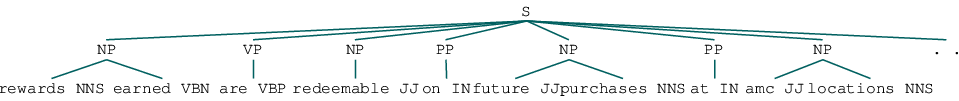

In [1222]:
chunk_tree

#### spacy

In [1252]:
from spacy import displacy

In [1253]:
displacy.render(line_spacy, style="dep")

In [1272]:
sample_ner = normdoc_tok[200:300]

In [1275]:
for line in sample_ner:
    line_spacy_ner = nlp(line) 
    # print named entities in article
    print([(word, word.ent_type_) for word in line_spacy if word.ent_type_])

    # visualize named entities
    displacy.render(line_spacy_ner, style='ent', jupyter=True)

[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


[]


## Fetching historical data

In [2162]:
from sklearn.preprocessing import Normalizer

In [2233]:
historical_stock_prices = pd.read_csv('../data/external/AMC.csv')
historical_stock_prices.Date = pd.to_datetime(amc_historical_stock_prices.Date)
historical_stock_prices.set_index('Date',inplace=True)
historical_stock_prices = amc_historical_stock_prices.set_index('Date').resample('Y').mean()
historical_stock_prices.reset_index(inplace=True)
historical_stock_prices.set_index(amc_historical_stock_prices.Date.dt.year,inplace=True)
historical_stock_prices['year'] = historical_stock_prices.Date.dt.year

In [2234]:
minmax_scaler = MinMaxScaler()

In [2235]:
standard_scaler = StandardScaler()
normalizer = Normalizer()

In [2236]:
historical_stock_prices['Close_scaled'] = minmax_scaler.fit_transform(historical_stock_prices[['Close']])

In [2237]:
historical_stock_prices['Close_diff'] = historical_stock_prices.Close_scaled.diff()

## Gensim - finding Similarity in documents

In [2130]:
#re.match('^[\,\.\d-]+$',',')

In [2131]:
def get_topwords(document,top=100):
    document = tokenize(document)
    document = remove_stopwords(document)
    document = remove_specific_chars(document)
    document = remove_numbers(document)
    document = nltk_lemmatizer(document)
    document_words = []
    for line in document:
        document_words += line
    top_words = []
    for item in Counter(document_words).most_common(top):
        top_words.append(item[0])
    return top_words

In [2132]:
top_docwords_df = pd.DataFrame(columns = ['ticker','date','topwords'])

In [2133]:
for i,row in tqdm(sec_fillings_df.iterrows(),desc='normalizing Fillings', \
                      unit='filling',total=len(sec_fillings_df)):
    top_docwords_list = get_topwords(row['normalized_filling'],500)
    top_docwords_df = top_docwords_df.append({'ticker':row['ticker'],'date':row['date'],'topwords':top_docwords_list},ignore_index=True)

normalizing Fillings: 100%|██████████| 8/8 [00:05<00:00,  1.44filling/s]


In [2134]:
top_docwords_df

,ticker,date,topwords
0,AMC,2021-03-12,"[december, million, company, note, due, theatre, year, ended, market, amch, asset, stock, common, value, interest, loss, expense, share, cash, us-gaap, related, lease, tax, financial, may, amount,..."
1,AMC,2020-02-28,"[december, company, million, year, note, ended, asset, due, lease, theatre, expense, amch, income, value, net, cash, tax, market, stock, share, common, loss, revenue, financial, cost, liability, u..."
2,AMC,2019-03-01,"[december, million, company, year, ended, due, note, theatre, income, asset, net, tax, cash, share, expense, cost, loss, revenue, value, stock, common, amc, market, acquisition, amount, agreement,..."
3,AMC,2018-03-01,"[december, million, company, year, ended, theatre, due, tax, note, net, asset, income, acquisition, loss, share, expense, revenue, cost, amc, cash, value, common, ncm, market, amount, stock, finan..."
4,AMC,2017-03-10,"[december, company, year, ended, note, due, theatre, amc, net, income, tax, asset, inc., expense, amount, revenue, cost, cash, holding, share, acquisition, stock, agreement, common, market, senior..."
5,AMC,2016-03-08,"[december, company, ended, note, month, inc., theatre, due, amc, holding, stock, year, financial, ncm, amount, tax, agreement, revenue, content, asset, twelve, expense, value, table, entertainment..."
6,AMC,2015-03-10,"[december, company, note, ended, theatre, month, ncm, due, stock, year, value, period, amount, financial, revenue, inc., content, asset, expense, tax, term, common, statement, share, table, holdin..."
7,AMC,2014-03-04,"[december, company, theatre, note, due, ended, year, inc., stock, march, amount, period, value, ncm, content, amc, common, revenue, holding, term, table, tax, asset, share, august, statement, fina..."


### Creating gensim dictionary

In [2135]:
document_list = []
for index,row in tqdm(sec_fillings_df.iterrows(),desc='normalizing Fillings', \
                      unit='filling',total=len(sec_fillings_df)):
    document = row['normalized_filling']
    document = tokenize(document)
    document = remove_stopwords(document)
    document = remove_specific_chars(document)
    document = remove_numbers(document)
    document = nltk_lemmatizer(document)
    document_words = []
    for line in document:
        document_words += line
    document_list.append(document_words)

normalizing Fillings: 100%|██████████| 8/8 [00:05<00:00,  1.42filling/s]


In [2136]:
gensim_dictionary = corpora.dictionary.Dictionary(document_list)

In [2137]:
gensim_corpus = [gensim_dictionary.doc2bow(document) for document in document_list]

In [2138]:
gensim_corpus_bow_df = pd.DataFrame(pd.to_datetime(sec_fillings_df.date).dt.year.to_numpy(),columns=['year'])

In [2139]:
gensim_corpus_bow_df['bow'] = gensim_corpus  

In [2140]:
# Sort the doc for frequency: bow_doc

# Create the defaultdict: total_word_count
total_word_count = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(gensim_corpus_bow_df.bow):
    total_word_count[word_id] += word_count
    
# Create a sorted list from the defaultdict: sorted_word_count
sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True) 

# Print the top 5 words across all documents alongside the count
for word_id, word_count in sorted_word_count[:10]:
    print(gensim_dictionary.get(word_id), word_count)

december 7568
company 5679
million 4051
year 3868
note 3722
ended 3642
due 3362
theatre 3361
asset 2493
tax 2364


### Using bow and jaccard similarity

In [2141]:
from gensim.matutils import jaccard

In [2142]:
year_list = pd.to_datetime(sec_fillings_df[sec_fillings_df.ticker=='AMC'].date).dt.year

In [2143]:
similarity_df = pd.DataFrame(year_list.to_numpy(),columns=['year'])

In [2144]:
similarity_df['gensim_jacc_score'] = 0 * len(similarity_df.index)

In [2145]:
gensim_corpus_bow_df

,year,bow
0,2021,"[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 3), (7, 3), (8, 1), (9, 1), (10, 1), (11, 2), (12, 4), (13, 2), (14, 1), (15, 29), (16, 5), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1..."
1,2020,"[(0, 1), (2, 1), (3, 1), (4, 1), (8, 1), (10, 1), (12, 4), (13, 2), (14, 1), (15, 25), (16, 3), (20, 1), (21, 1), (22, 1), (23, 13), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), ..."
2,2019,"[(12, 6), (13, 2), (15, 29), (16, 7), (22, 1), (23, 15), (25, 2), (40, 1), (41, 1), (42, 1), (43, 1), (90, 2), (99, 28), (103, 146), (104, 3), (105, 11), (106, 12), (110, 6), (117, 57), (118, 12),..."
3,2018,"[(15, 35), (16, 7), (22, 1), (23, 10), (25, 1), (40, 1), (41, 1), (90, 1), (99, 30), (103, 158), (104, 2), (106, 12), (110, 15), (117, 55), (118, 15), (123, 2), (125, 1), (126, 14), (127, 3), (128..."
4,2017,"[(4, 1), (15, 73), (16, 12), (22, 2), (23, 13), (99, 53), (103, 117), (104, 2), (106, 15), (110, 8), (117, 47), (118, 18), (123, 1), (125, 1), (126, 17), (127, 4), (128, 6), (129, 4), (130, 2), (1..."
5,2016,"[(15, 48), (16, 12), (22, 2), (23, 11), (90, 1), (99, 23), (103, 53), (104, 2), (106, 7), (111, 1), (117, 38), (118, 15), (124, 1), (125, 1), (126, 27), (127, 4), (128, 5), (130, 1), (131, 16), (1..."
6,2015,"[(15, 20), (16, 16), (23, 3), (90, 1), (99, 8), (103, 59), (104, 2), (106, 1), (111, 2), (117, 36), (118, 20), (125, 1), (126, 26), (127, 4), (128, 5), (130, 1), (131, 17), (132, 16), (133, 2), (1..."
7,2014,"[(15, 26), (16, 13), (23, 3), (99, 18), (103, 61), (104, 2), (106, 4), (117, 39), (118, 18), (125, 1), (126, 15), (127, 3), (128, 6), (130, 1), (131, 21), (132, 19), (133, 2), (135, 2), (136, 4), ..."


In [2146]:
for i,row in gensim_corpus_bow_df.iterrows():
    if i < (len(gensim_corpus_bow_df.index)-1):
        similarity_df.loc[similarity_df.year == row.year,'gensim_jacc_score'] = jaccard(row['bow'],gensim_corpus_bow_df.iloc[i+1]['bow'])

In [2178]:
similarity_vs_stockprices = historical_stock_prices.merge(similarity_df,on='year')

<AxesSubplot:xlabel='year'>

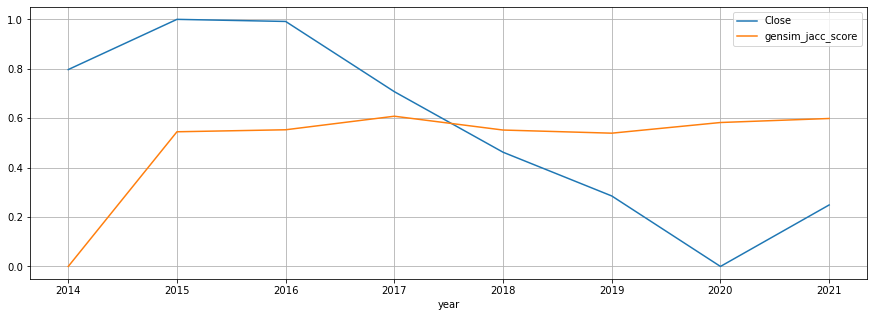

In [2181]:
similarity_vs_stockprices.plot(x='year',y=['Close','gensim_jacc_score'],figsize=(15,5),grid=True)

<B>Jaccard similarity with bag of words is not great at highlighting the changes in the documents.
    What is required is more 

### TF-IDF & SparseMatrixSimilarity

In [2149]:
# Create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(gensim_corpus)

# Calculate the tfidf weights of doc: tfidf_weights
doc = gensim_corpus[0]
tfidf_weights = tfidf[doc]

# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

# Print the top 5 weighted words
for term_id, weight in sorted_tfidf_weights[:5]:
    print(gensim_dictionary.get(term_id), weight)

amch 0.6443279592392185
us-gaap 0.4845920584807493
covid-19 0.33921444093652453
pandemic 0.16870982776737198
srt 0.15973590075846922


In [2150]:
top_tfidfwords_df = pd.DataFrame(columns = ['ticker','date','topwords'])

In [2151]:
for i,row in sec_fillings_df.iterrows():
    doc = gensim_corpus[i]
    tfidf_weights = tfidf[doc]
    sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)[:5]
    sorted_tfidf_words = []
    for term_id, weight in sorted_tfidf_weights[:5]:
        sorted_tfidf_words.append(gensim_dictionary.get(term_id))
    top_tfidfwords_df = top_tfidfwords_df.append({'ticker':row['ticker'],'date':row['date'],'topwords':sorted_tfidf_words},ignore_index=True)

In [2152]:
top_tfidfwords_df

,ticker,date,topwords
0,AMC,2021-03-12,"[amch, us-gaap, covid-19, pandemic, srt]"
1,AMC,2020-02-28,"[amch, us-gaap, srt, percentdue, nationalcinemediallcmember]"
2,AMC,2019-03-01,"[odeon, nordic, sterling, bridge, amcs]"
3,AMC,2018-03-01,"[odeon, nordic, sterling, ncms, carmike]"
4,AMC,2017-03-10,"[odeon, amces, amce, legacy, nordic]"
5,AMC,2016-03-08,"[amce, twelve, smh, packaged, ipo]"
6,AMC,2015-03-10,"[amce, twelve, predecessor, packaged, red]"
7,AMC,2014-03-04,"[amce, cinemex, predecessor, entretenimiento, orf]"


In [2153]:
gensim_corpus_tfidf = tfidf[gensim_corpus]

In [2154]:
similarity_matrix = similarities.SparseMatrixSimilarity(gensim_corpus_tfidf,num_features=len(gensim_dictionary))

In [2155]:
gensim_sims = similarity_matrix.get_similarities(gensim_corpus_tfidf)

In [2184]:
similarity_df['gensim_tfidf_sim'] = 0 * len(gensim_sims_df.index)

In [2185]:
for i in range(len(gensim_sims)-1):
    similarity_df.loc[i,'gensim_tfidf_sim'] = gensim_sims[i][i+1]

In [2186]:
similarity_vs_stockprices = similarity_vs_stockprices.merge(similarity_df[['year','gensim_tfidf_sim']],on='year')

<AxesSubplot:xlabel='year'>

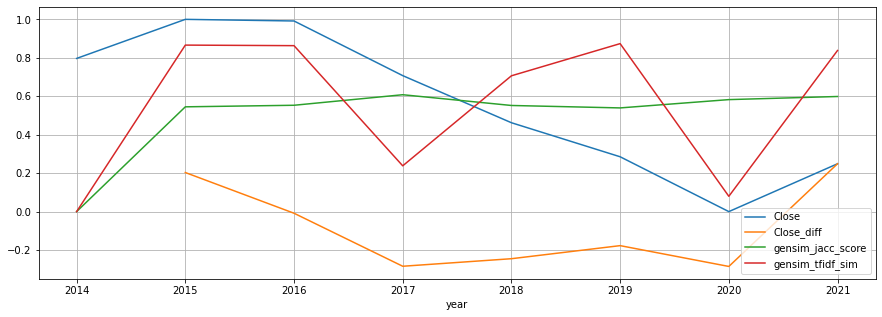

In [2187]:
similarity_vs_stockprices.plot(x='year',y=['Close','Close_diff','gensim_jacc_score','gensim_tfidf_sim'],figsize=(15,5),grid=True)

### Word2Vec & SoftCosineSimilarity

In [1658]:
gensim_w2v_model = Word2Vec(gensim_corpus)

In [1659]:
wordemb_sim_index = WordEmbeddingSimilarityIndex(gensim_w2v_model.wv)

In [1660]:
similarity_matrix = SparseTermSimilarityMatrix(wordemb_sim_index, gensim_dictionary)

100%|██████████| 6950/6950 [00:00<00:00, 108309.48it/s]


In [1661]:
softcos_sim_index = SoftCosineSimilarity(gensim_corpus_tfidf, similarity_matrix)

In [1662]:
gensim_softcos_sims = softcos_sim_index.get_similarities(gensim_corpus_tfidf)

In [2188]:
similarity_df['gensim_softcos_sim'] = 0 * len(similarity_df.index)
for i in range(len(gensim_softcos_sims)-1):
    similarity_df.loc[i,'gensim_softcos_sim'] = gensim_softcos_sims[i][i+1]

In [2189]:
similarity_vs_stockprices = similarity_vs_stockprices.merge(similarity_df[['year','gensim_softcos_sim']],on='year')

In [2190]:
similarity_vs_stockprices

,Date,Open,High,Low,Close,Adj Close,Volume,year,Close_diff,gensim_jacc_score,gensim_tfidf_sim_x,gensim_tfidf_sim_y,gensim_tfidf_sim,gensim_softcos_sim
0,2014-12-31,23.862000,25.522000,22.293000,0.796743,17.549671,5.213930e+06,2014,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
1,2015-12-31,29.458333,31.161667,26.827500,1.000000,21.755038,5.655683e+06,2015,0.203257,0.545024,0.866074,0.866074,0.866074,0.866066
2,2016-12-31,28.077500,30.495000,26.644167,0.991520,22.278353,5.912350e+06,2016,-0.008480,0.553141,0.863190,0.863190,0.863190,0.863193
3,2017-12-31,23.620833,24.969166,20.815834,0.707282,17.307974,4.927905e+07,2017,-0.284239,0.607955,0.238131,0.238131,0.238131,0.238132
4,2018-12-31,16.283333,17.958333,14.378333,0.462279,13.482585,3.781455e+07,2018,-0.245003,0.552042,0.706411,0.706411,0.706411,0.706409
5,2019-12-31,12.117500,13.080833,10.618333,0.285248,10.894159,4.816236e+07,2019,-0.177031,0.539351,0.873786,0.873786,0.873786,0.873790
6,2020-12-31,4.864167,6.237500,3.444167,0.000000,4.463567,2.269512e+08,2020,-0.285248,0.582520,0.079636,0.079636,0.079636,0.079636
7,2021-12-31,9.600000,18.805000,3.585000,0.248873,10.635000,4.124496e+09,2021,0.248873,0.598761,0.838070,0.838070,0.838070,0.838063


<AxesSubplot:xlabel='year'>

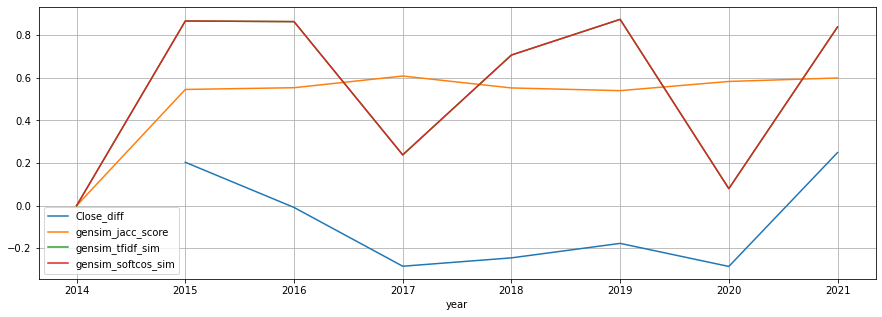

In [2191]:
similarity_vs_stockprices.plot(x='year',y=['Close_diff','gensim_jacc_score','gensim_tfidf_sim','gensim_softcos_sim'],figsize=(15,5),grid=True)

<B>Both sklearn cosine similarity and gensim softcosin similarity based of tfidf mimic the trend in avg stock close prices of that year.
   meanwhile Jaccard similarity based on bow corpus is not so indicative of the stock price trend.

### sklearn CountVectorizer & jaccard similarity

In [1667]:
from sklearn.metrics import jaccard_score

In [1668]:
alldoc_word_list = []
for word_list in document_list:
    alldoc_word_list +=word_list

In [1669]:
alldoc_words = sorted(set(alldoc_word_list))

In [1693]:
documents_lines_list = [' '.join(doc) for doc in document_list]

In [1694]:
vec = CountVectorizer(vocabulary=alldoc_words)

In [1695]:
vectors = vec.fit_transform(documents_lines_list)
sk_bow = []
for i in range(len(document_list)):
        sk_bow.append(vectors[i].toarray()[0])

In [2205]:
similarity_df['sklearn_jacc_score'] = 0 * len(similarity_df.index)

In [2206]:
for i,row in similarity_df.iterrows():
    if i < (len(similarity_df.index)-1):
        u = sk_bow[i]
        v = sk_bow[i+1]
        similarity_df.loc[similarity_df.year == row.year,'sklearn_jacc_score'] = jaccard_score(u,v,average='weighted')

In [2207]:
similarity_vs_stockprices = similarity_vs_stockprices.merge(similarity_df[['year','sklearn_jacc_score']],on='year')

### sklearn TfidfVectorizer & cosine similarity

In [2192]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [2193]:
from sklearn.metrics.pairwise import cosine_similarity

In [2194]:
vec = TfidfVectorizer(vocabulary=alldoc_words)
tfidf = vec.fit_transform(documents_lines_list)

In [2195]:
cosine_similarity(tfidf[0].reshape(1, -1),tfidf[1].reshape(1, -1))

array([[0.95162102]])

In [2196]:
for i,row in similarity_df.iterrows():
    if i < (len(similarity_df.index)-1):
        similarity_df.loc[similarity_df.year == row.year,'sklearn_cosine_sim'] = cosine_similarity(tfidf[i].reshape(1, -1),tfidf[i+1].reshape(1, -1))

In [2197]:
similarity_df['sklearn_cosine_sim'] = minmax_scaler.fit_transform(similarity_df[['sklearn_cosine_sim']])

In [2198]:
similarity_df

,year,gensim_jacc_score,gensim_tfidf_sim,gensim_softcos_sim,sklearn_cosine_sim
0,2021,0.598761,0.838070,0.838063,0.452297
1,2020,0.582520,0.079636,0.079636,0.000000
2,2019,0.539351,0.873786,0.873790,1.000000
3,2018,0.552042,0.706411,0.706409,0.442344
4,2017,0.607955,0.238131,0.238132,0.204397
5,2016,0.553141,0.863190,0.863193,0.778088
6,2015,0.545024,0.866074,0.866066,0.874092
7,2014,0.000000,0.000000,0.000000,NaN


In [2202]:
similarity_vs_stockprices = similarity_vs_stockprices.merge(similarity_df[['year','sklearn_cosine_sim']],on='year')

<AxesSubplot:xlabel='year'>

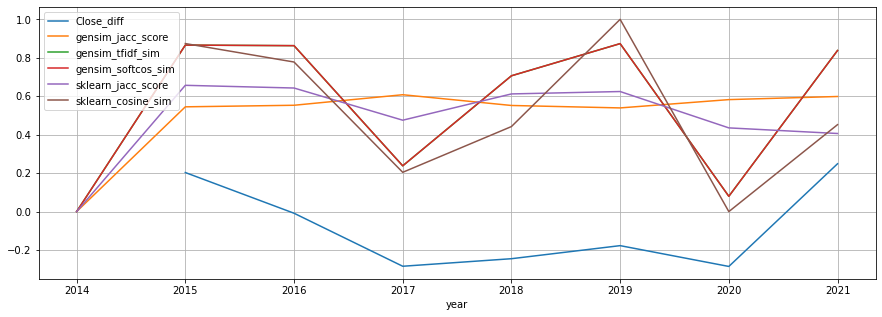

In [2208]:
similarity_vs_stockprices.plot(x='year',y=['Close_diff','gensim_jacc_score','gensim_tfidf_sim','gensim_softcos_sim','sklearn_jacc_score','sklearn_cosine_sim'],figsize=(15,5),grid=True)

## Similarity check with sentiment categories

In [1765]:
sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

In [1766]:
sentiment_df = pd.read_csv('../data/external/LoughranMcDonald_MasterDictionary_2018.csv')

In [1784]:
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df.astype({col : 'bool' for col in sentiments})

In [1787]:
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

In [1789]:
sentiment_df['word'] = sentiment_df['word'].str.lower()
lemmatizer = WordNetLemmatizer()
sentiment_df[['word']] = [lemmatizer.lemmatize(word) for word in sentiment_df.word]
sentiment_df = sentiment_df.drop_duplicates('word')

In [518]:
sentiment_df.word.to_list()

['abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abdicated',
 'abdicates',
 'abdicating',
 'abdication',
 'aberrant',
 'aberration',
 'aberrational',
 'abetting',
 'abeyance',
 'abide',
 'abiding',
 'able',
 'abnormal',
 'abnormality',
 'abnormally',
 'abolish',
 'abolished',
 'abolishes',
 'abolishing',
 'abovementioned',
 'abrogate',
 'abrogated',
 'abrogates',
 'abrogating',
 'abrogation',
 'abrupt',
 'abruptly',
 'abruptness',
 'absence',
 'absenteeism',
 'absolve',
 'absolved',
 'absolves',
 'absolving',
 'abundance',
 'abundant',
 'abuse',
 'abused',
 'abusing',
 'abusive',
 'abusively',
 'abusiveness',
 'accession',
 'accident',
 'accidental',
 'accidentally',
 'acclaimed',
 'accomplish',
 'accomplished',
 'accomplishes',
 'accomplishing',
 'accomplishment',
 'accusation',
 'accuse',
 'accused',
 'accuses',
 'accusing',
 'achieve',
 'achieved',
 'achievement',
 'achieves',
 'achieving',
 'acquiesce',
 'acquiesced',
 'acquiesces',
 'acquiescing',
 'acquirees',
 'acquiro

### sklearn CountVectorizer & jaccard similarity

In [2209]:
mul_index = pd.MultiIndex.from_product([year_list,sentiments],names=('year','sentiment'))

In [2210]:
sentiments_sim_df = pd.DataFrame(index=mul_index)

In [2211]:
def get_sentiment_bow(word_list,documents):
    vec = CountVectorizer(vocabulary=word_list)
    vectors = vec.fit_transform(documents)
    sk_bow = []
    for i in range(len(documents)):
        sk_bow.append(vectors[i].toarray()[0])
    return sk_bow

In [2212]:
sentiments_sk_bow = {}

In [2213]:
for sentiment in sentiments:
    sentiment_words = sentiment_df[sentiment_df[sentiment]]['word']
    sentiments_sk_bow.update({sentiment:get_sentiment_bow(sentiment_words,documents_lines_list)})

In [2214]:
for i,year in enumerate(year_list):
    if i < (len(year_list)-1):
        for sentiment in sentiments:
            u = sentiments_sk_bow.get(sentiment)[i]
            v = sentiments_sk_bow.get(sentiment)[i+1]
            sentiments_sim_df.loc[(year,sentiment),'sklearn_jacc_score'] = jaccard_score(u,v,average='weighted')

In [2215]:
sentiments_sim_df

sklearn_jacc_score
year sentiment                       
2021 negative                0.896639
     positive                0.759042
     uncertainty             0.694057
     litigious               0.904958
     constraining            0.674716
     interesting             0.828336
2020 negative                0.935128
     positive                0.707089
     uncertainty             0.743056
     litigious               0.923211
     constraining            0.781849
     interesting             0.746832
2019 negative                0.933791
     positive                0.795152
     uncertainty             0.810072
     litigious               0.915592
     constraining            0.826116
     interesting             0.814977
2018 negative                0.942224
     positive                0.820990
     uncertainty             0.783677
     litigious               0.927178
     constraining            0.758987
     interesting             0.834477
2017 negative                0.917308
     positive                0.662946
     uncertainty             0.757376
     litigious               0.909367
     constraining            0.782821
     interesting             0.725528
2016 negative                0.946341
     positive                0.808532
     uncertainty             0.821838
     litigious               0.915222
     constraining            0.814457
     interesting             0.764219
2015 negative                0.951009
     positive                0.808472
     uncertainty             0.852614
     litigious               0.922752
     constraining            0.794777
     interesting             0.828283
2014 negative                     NaN
     positive                     NaN
     uncertainty                  NaN
     litigious                    NaN
     constraining                 NaN
     interesting                  NaN

### sklearn TfidfVectorizer & cosine similarity

In [2238]:
def get_sentiment_tfidf(word_list,documents):
    vec = TfidfVectorizer(vocabulary=word_list)
    tfidf = vec.fit_transform(documents)
    sk_tfidf = []
    for i in range(len(documents)):
        sk_tfidf.append(tfidf[i].reshape(1,-1))
    return tfidf

In [2239]:
sentiments_sk_tfidf = {}
for sentiment in sentiments:
    sentiment_words = sentiment_df[sentiment_df[sentiment]]['word']
    sentiments_sk_tfidf.update({sentiment:get_sentiment_tfidf(sentiment_words,documents_lines_list)})

In [2240]:
for i,year in enumerate(year_list):
    if i < (len(year_list)-1):
        for sentiment in sentiments:
            u = sentiments_sk_tfidf.get(sentiment)[i]
            v = sentiments_sk_tfidf.get(sentiment)[i+1]
            sentiments_sim_df.loc[(year,sentiment),'sklearn_cossine_score'] = cosine_similarity(u,v)[0][0]

In [2241]:
sentiments_sim_df_unstacked = sentiments_sim_df.query('year > 2014').unstack()

In [2242]:
sentiments_sim_df_unstacked['Close'] = historical_stock_prices.query('year > 2014')['Close']

In [2243]:
sentiments_sim_df_unstacked['Close_diff'] = historical_stock_prices.query('year > 2014')['Close_diff']

<AxesSubplot:xlabel='year'>

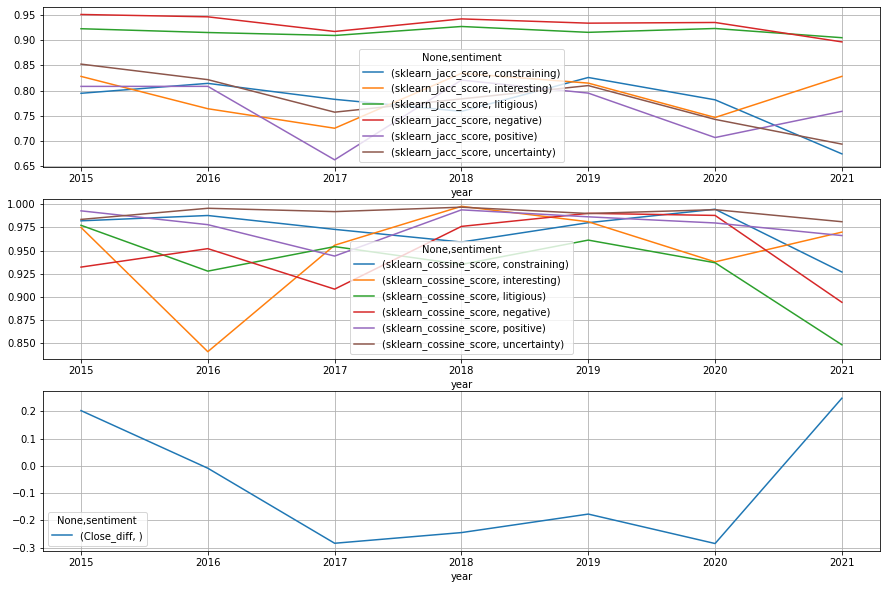

In [2249]:
fig , ax = plt.subplots(3,1,figsize=(15,10))
sentiments_sim_df_unstacked.loc[:,['sklearn_jacc_score']].plot(ax=ax[0],grid=True)
sentiments_sim_df_unstacked.loc[:,['sklearn_cossine_score']].plot(ax = ax[1],grid=True)
sentiments_sim_df_unstacked.loc[:,['Close_diff']].plot(ax = ax[2],grid=True)
#plt.legend(loc='right',bbox_to_anchor=(1.25, 0.5)) 

<B> Differences in documents based of sentiments are not clearly indicative of the underlying stock price trend. 
But still more analysis needs to be done to find something more conclusive.